In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import holidays
import seaborn as sns
from google.colab import files

In [3]:
data_dir = '/content/drive/My Drive/MIE498 Thesis/0_Data'

# 1.0 Toronto Bikeshare Ridership Data Pre-processing (2019)

## 1.1 Read in data

In [4]:
# Read in data
data_2019Q1 = pd.read_csv("{}/bikeshare2019/2019-Q1.csv".format(data_dir), header=0)
data_2019Q2 = pd.read_csv("{}/bikeshare2019/2019-Q2.csv".format(data_dir), header=0)
data_2019Q3 = pd.read_csv("{}/bikeshare2019/2019-Q3.csv".format(data_dir), header=0)
data_2019Q4 = pd.read_csv("{}/bikeshare2019/2019-Q4.csv".format(data_dir), header=0)

In [5]:
print(data_2019Q1.shape, list(data_2019Q1.columns))
print(data_2019Q2.shape, list(data_2019Q2.columns))
print(data_2019Q3.shape, list(data_2019Q3.columns))
print(data_2019Q4.shape, list(data_2019Q4.columns))

(189063, 10) ['Trip Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']
(651685, 10) ['Trip Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']
(1130353, 10) ['Trip Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']
(468416, 10) ['Trip Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']


## 1.2 Check for null values and discard them + Join quarterly data into one DataFrame

In [6]:
data_2019Q1.isnull().sum()

Trip Id               0
Trip  Duration        7
Start Station Id      0
Start Time            0
Start Station Name    0
End Station Id        0
End Time              0
End Station Name      0
Bike Id               0
User Type             0
dtype: int64

In [7]:
data_2019Q2.isnull().sum()

Trip Id               0
Trip  Duration        4
Start Station Id      0
Start Time            0
Start Station Name    0
End Station Id        1
End Time              0
End Station Name      1
Bike Id               0
User Type             0
dtype: int64

In [8]:
data_2019Q3.isnull().sum()

Trip Id                0
Trip  Duration         3
Start Station Id       0
Start Time             0
Start Station Name     0
End Station Id        19
End Time               0
End Station Name      19
Bike Id                0
User Type              0
dtype: int64

In [9]:
data_2019Q4.isnull().sum()

Trip Id                 0
Trip  Duration          2
Start Station Id        0
Start Time              0
Start Station Name      0
End Station Id        434
End Time                0
End Station Name      434
Bike Id                 0
User Type               0
dtype: int64

In [10]:
# Join DataFrames
data_2019_all = pd.concat([data_2019Q1, data_2019Q2, data_2019Q3, data_2019Q4])
print("Before dropna:", data_2019_all.shape)

data_2019_all.dropna(inplace=True)

print("After dropna:", data_2019_all.shape)
data_2019_all.head()

Before dropna: (2439517, 10)
After dropna: (2439047, 10)


,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,4581278,1547.0,7021,01/01/2019 00:08,Bay St / Albert St,7233.0,01/01/2019 00:33,King / Cowan Ave - SMART,1296,Annual Member
1,4581279,1112.0,7160,01/01/2019 00:10,King St W / Tecumseth St,7051.0,01/01/2019 00:29,Wellesley St E / Yonge St (Green P),2947,Annual Member
2,4581280,589.0,7055,01/01/2019 00:15,Jarvis St / Carlton St,7013.0,01/01/2019 00:25,Scott St / The Esplanade,2293,Annual Member
3,4581281,259.0,7012,01/01/2019 00:16,Elizabeth St / Edward St (Bus Terminal),7235.0,01/01/2019 00:20,Bay St / College St (West Side) - SMART,283,Annual Member
4,4581282,281.0,7041,01/01/2019 00:19,Edward St / Yonge St,7257.0,01/01/2019 00:24,Dundas St W / St. Patrick St,1799,Annual Member


In [11]:
data_2019_all.isnull().sum()

Trip Id               0
Trip  Duration        0
Start Station Id      0
Start Time            0
Start Station Name    0
End Station Id        0
End Time              0
End Station Name      0
Bike Id               0
User Type             0
dtype: int64

In [12]:
# Reorder columns
data_2019_all = pd.concat([data_2019_all.iloc[:, 0:8], data_2019_all.iloc[:, 9], data_2019_all.iloc[:, 8]], axis=1)
# Rename columns
column_names = ['Trip Id', 'Trip Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'User Type', 'Bike Id']
data_2019_all.columns = column_names

print(data_2019_all.shape)
data_2019_all.head()

(2439047, 10)


,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,Bike Id
0,4581278,1547.0,7021,01/01/2019 00:08,Bay St / Albert St,7233.0,01/01/2019 00:33,King / Cowan Ave - SMART,Annual Member,1296
1,4581279,1112.0,7160,01/01/2019 00:10,King St W / Tecumseth St,7051.0,01/01/2019 00:29,Wellesley St E / Yonge St (Green P),Annual Member,2947
2,4581280,589.0,7055,01/01/2019 00:15,Jarvis St / Carlton St,7013.0,01/01/2019 00:25,Scott St / The Esplanade,Annual Member,2293
3,4581281,259.0,7012,01/01/2019 00:16,Elizabeth St / Edward St (Bus Terminal),7235.0,01/01/2019 00:20,Bay St / College St (West Side) - SMART,Annual Member,283
4,4581282,281.0,7041,01/01/2019 00:19,Edward St / Yonge St,7257.0,01/01/2019 00:24,Dundas St W / St. Patrick St,Annual Member,1799


In [13]:
data_2019_all.dtypes

Trip Id                 int64
Trip Duration         float64
Start Station Id        int64
Start Time             object
Start Station Name     object
End Station Id        float64
End Time               object
End Station Name       object
User Type              object
Bike Id                 int64
dtype: object

## 1.3 Some function definitions for data pre-processing

In [14]:
def convert_column_data_types(df):
  # Convert columns into appropriate data types
  df['Trip Id'] = df['Trip Id'].astype("int64")
  df['Trip Duration'] = df['Trip Duration'].astype("float64")
  df['Start Station Id'] = df['Start Station Id'].astype("string").astype("int64")
  df['Start Time'] = df.apply(lambda row: datetime.strptime(row['Start Time'], "%m/%d/%Y %H:%M"), axis=1)
  df['Start Station Name'] = df['Start Station Name'].astype("string")
  df['End Station Id'] = df['End Station Id'].astype("int64")
  df['End Time'] = df.apply(lambda row: datetime.strptime(row['End Time'], "%m/%d/%Y %H:%M"), axis=1)
  df['End Station Name'] = df['End Station Name'].astype("string")
  df['User Type'] = df['User Type'].astype("string")
  if 'Bike Id' in df.columns:
    df['Bike Id'] = df['Bike Id'].astype("int64")

  return df

In [15]:
def check_holidays(date, holidays_can_on):
    if date in holidays_can_on: 
      return 1
    else: 
      return 0

In [16]:
def add_and_modify_columns(df, yrs):
  holidays_can_on = list(holidays.CA(years=yrs, prov='ON').keys())
  
  if yrs[0] == 2017 or yrs[0] == 2018:
    df['User Type'].replace(to_replace='Casual', value='Casual Member', inplace=True)
    df['User Type'].replace(ro_replace='Member', value='Annual Member', inplace=True) 

  # Start Time
  df['Start Year'] = df.apply(lambda row: row['Start Time'].year, axis=1)
  df['Start Month'] = df.apply(lambda row: row['Start Time'].month, axis=1)
  df['Start Hour'] = df.apply(lambda row: row['Start Time'].hour, axis=1)
  df['Start Day of Week'] = df.apply(lambda row: row['Start Time'].weekday(), axis=1)
  df['Start Hour'] = df.apply(lambda row: row['Start Time'].hour, axis=1)
  df['Start Holiday'] = df.apply(lambda row: check_holidays(row['Start Time'], holidays_can_on), axis=1)

  # End Time
  df['End Year'] = df.apply(lambda row: row['End Time'].year, axis=1)
  df['End Month'] = df.apply(lambda row: row['End Time'].month, axis=1)
  df['End Hour'] = df.apply(lambda row: row['End Time'].hour, axis=1)
  df['End Day of Week'] = df.apply(lambda row: row['End Time'].weekday(), axis=1)
  df['End Hour'] = df.apply(lambda row: row['End Time'].hour, axis=1)
  df['End Holiday'] = df.apply(lambda row: check_holidays(row['End Time'], holidays_can_on), axis=1)

  return df

## 1.4 Pre-process data
* convert column data types to appropriate types
* add additional columns

In [17]:
yrs = [2019]
data_2019_all_cleaned = convert_column_data_types(data_2019_all)
data_2019_all_cleaned = add_and_modify_columns(data_2019_all_cleaned, yrs)
print(data_2019_all_cleaned.shape)
data_2019_all_cleaned.head()

(2439047, 20)


,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,Bike Id,Start Year,Start Month,Start Hour,Start Day of Week,Start Holiday,End Year,End Month,End Hour,End Day of Week,End Holiday
0,4581278,1547.0,7021,2019-01-01 00:08:00,Bay St / Albert St,7233,2019-01-01 00:33:00,King / Cowan Ave - SMART,Annual Member,1296,2019,1,0,1,1,2019,1,0,1,1
1,4581279,1112.0,7160,2019-01-01 00:10:00,King St W / Tecumseth St,7051,2019-01-01 00:29:00,Wellesley St E / Yonge St (Green P),Annual Member,2947,2019,1,0,1,1,2019,1,0,1,1
2,4581280,589.0,7055,2019-01-01 00:15:00,Jarvis St / Carlton St,7013,2019-01-01 00:25:00,Scott St / The Esplanade,Annual Member,2293,2019,1,0,1,1,2019,1,0,1,1
3,4581281,259.0,7012,2019-01-01 00:16:00,Elizabeth St / Edward St (Bus Terminal),7235,2019-01-01 00:20:00,Bay St / College St (West Side) - SMART,Annual Member,283,2019,1,0,1,1,2019,1,0,1,1
4,4581282,281.0,7041,2019-01-01 00:19:00,Edward St / Yonge St,7257,2019-01-01 00:24:00,Dundas St W / St. Patrick St,Annual Member,1799,2019,1,0,1,1,2019,1,0,1,1


In [18]:
data_2019_all_cleaned.reset_index(drop=True, inplace=True)

In [19]:
data_2019_all_cleaned['Start Day of Year'] = data_2019_all_cleaned.apply(lambda row: row['Start Time'].timetuple().tm_yday, axis=1)

In [20]:
data_2019_all_cleaned['Start Week of Year'] = data_2019_all_cleaned.apply(lambda row: row['Start Time'].isocalendar()[1], axis=1)

In [21]:
print(data_2019_all_cleaned.shape)
data_2019_all_cleaned.tail()

(2439047, 22)


,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,Bike Id,Start Year,Start Month,Start Hour,Start Day of Week,Start Holiday,End Year,End Month,End Hour,End Day of Week,End Holiday,Start Day of Year,Start Week of Year
2439042,7334123,523.0,7098,2019-12-31 23:39:00,Riverdale Park South (Broadview Ave),7339,2019-12-31 23:48:00,Carlaw Ave / Strathcona Ave,Annual Member,861,2019,12,23,1,0,2019,12,23,1,0,365,1
2439043,7334124,273.0,7044,2019-12-31 23:45:00,Church St / Alexander St,7273,2019-12-31 23:49:00,Bay St / Charles St - SMART,Annual Member,3776,2019,12,23,1,0,2019,12,23,1,0,365,1
2439044,7334125,1055.0,7100,2019-12-31 23:51:00,Dundas St E / Regent Park Blvd,7100,2020-01-01 00:08:00,Dundas St E / Regent Park Blvd,Annual Member,2382,2019,12,23,1,0,2020,1,0,2,0,365,1
2439045,7334126,459.0,7470,2019-12-31 23:55:00,York St / Lake Shore Blvd W,7102,2020-01-01 00:03:00,Nelson St / Duncan St,Annual Member,2800,2019,12,23,1,0,2020,1,0,2,0,365,1
2439046,7334127,361.0,7168,2019-12-31 23:58:00,Queens Quay / Yonge St,7033,2020-01-01 00:04:00,Union Station,Annual Member,4139,2019,12,23,1,0,2020,1,0,2,0,365,1


In [ ]:
data_2019_all_cleaned.to_csv('cleaned_data_2019.csv', index=False, header=True)
files.download('cleaned_data_2019.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2.0 Analyze some general information about the ridership data

In [22]:
data_2019_all_cleaned = pd.read_csv("{}/cleaned_data_2019.csv".format(data_dir), header=0)
print(data_2019_all_cleaned.shape)
data_2019_all_cleaned.head()

(2439047, 22)


,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,Bike Id,Start Year,Start Month,Start Hour,Start Day of Week,Start Holiday,End Year,End Month,End Hour,End Day of Week,End Holiday,Start Day of Year,Start Week of Year
0,4581278,1547.0,7021,2019-01-01 00:08:00,Bay St / Albert St,7233,2019-01-01 00:33:00,King / Cowan Ave - SMART,Annual Member,1296,2019,1,0,1,1,2019,1,0,1,1,1,1
1,4581279,1112.0,7160,2019-01-01 00:10:00,King St W / Tecumseth St,7051,2019-01-01 00:29:00,Wellesley St E / Yonge St (Green P),Annual Member,2947,2019,1,0,1,1,2019,1,0,1,1,1,1
2,4581280,589.0,7055,2019-01-01 00:15:00,Jarvis St / Carlton St,7013,2019-01-01 00:25:00,Scott St / The Esplanade,Annual Member,2293,2019,1,0,1,1,2019,1,0,1,1,1,1
3,4581281,259.0,7012,2019-01-01 00:16:00,Elizabeth St / Edward St (Bus Terminal),7235,2019-01-01 00:20:00,Bay St / College St (West Side) - SMART,Annual Member,283,2019,1,0,1,1,2019,1,0,1,1,1,1
4,4581282,281.0,7041,2019-01-01 00:19:00,Edward St / Yonge St,7257,2019-01-01 00:24:00,Dundas St W / St. Patrick St,Annual Member,1799,2019,1,0,1,1,2019,1,0,1,1,1,1


In [23]:
print('Total number of bikes:', len(data_2019_all_cleaned['Bike Id'].unique()))
print('Number of start stations:', len(data_2019_all_cleaned['Start Station Id'].unique()))
print('Number of end stations:', len(data_2019_all_cleaned['End Station Id'].unique()))
start_end_stations = list(data_2019_all_cleaned['Start Station Id'].unique())+list(data_2019_all_cleaned['End Station Id'].unique())
print('Total number of stations:', len(set(start_end_stations)))
print('Total number of trips recorded', data_2019_all_cleaned.shape[0])

Total number of bikes: 4901
Number of start stations: 469
Number of end stations: 468
Total number of stations: 469
Total number of trips recorded 2439047


In [24]:
annual = round(data_2019_all_cleaned[data_2019_all_cleaned['User Type']=='Annual Member'].shape[0]/data_2019_all_cleaned.shape[0]*100, 2)
casual = round(data_2019_all_cleaned[data_2019_all_cleaned['User Type']=='Casual Member'].shape[0]/data_2019_all_cleaned.shape[0]*100, 2)
print('Percent of total number of trips taken by ANNUAL users: {}%'.format(annual))
print('Percent of total number of trips taken by CASUAL users: {}%'.format(casual))

Percent of total number of trips taken by ANNUAL users: 76.22%
Percent of total number of trips taken by CASUAL users: 23.78%


In [25]:
data_2019_all_cleaned['Start Time']

0          2019-01-01 00:08:00
1          2019-01-01 00:10:00
2          2019-01-01 00:15:00
3          2019-01-01 00:16:00
4          2019-01-01 00:19:00
                  ...         
2439042    2019-12-31 23:39:00
2439043    2019-12-31 23:45:00
2439044    2019-12-31 23:51:00
2439045    2019-12-31 23:55:00
2439046    2019-12-31 23:58:00
Name: Start Time, Length: 2439047, dtype: object

# 3.0 Creating Plots and Performing EDA
**Plots Contained Below:**

* **Bike usage patterns within a year**
    * **Box plot (2019)**: x=2019, y=average daily uses per bike
    * **Line plot (2019)**: x=Jan/Feb/.../Dec, y=average daily uses per bike
    * **Box plot (2019)**: x=2019, y=trip duration --> check for outliers
    * **Histograms, 12 subplots (month pattern, 2019)**: x=trip duration for each month (also by type of user)

* **Bike usage pattern within a week**
    * **Box plots (week pattern, 2019)**: x=Mon/Tue/.../Sun, y=number of trips

* **Bike usage patterns within a weekday/weekend/holiday**
    * **Line plots (hour pattern, 2019)**: x=departure hour, y=number of trips (% in this hour on an average weekday/weekend/holiday), 3 lines -- 1 for weekday (Mon-Fri), 1 for weekend, 1 for holiday


## 3.1 Box plot (2019): x=2019, y=average daily uses per bike

In [26]:
total_num_bikes = len(data_2019_all_cleaned['Bike Id'].unique())
avg_daily_use_per_bike = data_2019_all_cleaned[['Trip Id', 'Start Day of Year']]
avg_daily_use_per_bike = avg_daily_use_per_bike.groupby(by=['Start Day of Year']).count()
avg_daily_use_per_bike['Average Daily Use Per Bike'] = avg_daily_use_per_bike.apply(lambda row: round(row['Trip Id']/total_num_bikes, 3), axis=1)
avg_daily_use_per_bike.drop(columns=['Trip Id'], inplace=True)
avg_daily_use_per_bike

,Average Daily Use Per Bike
Start Day of Year,
1,0.217
2,0.467
3,0.465
4,0.671
5,0.441
...,...
361,0.527
362,0.510
363,0.209


In [27]:
avg_daily_use_per_bike.describe()

,Average Daily Use Per Bike
count,365.000000
mean,1.363468
std,0.902426
min,0.045000
25%,0.557000
50%,1.201000
75%,2.166000
max,4.334000


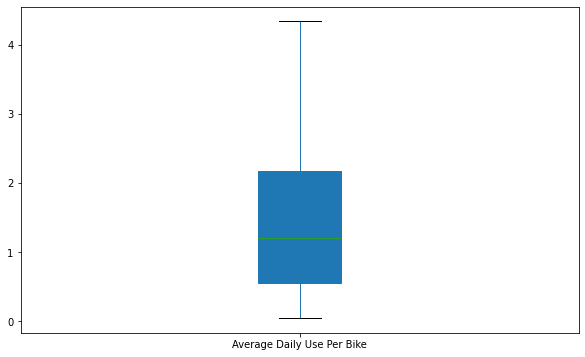

In [28]:
avg_daily_use_per_bike.plot(kind='box', figsize=(10, 6), patch_artist=True)

## 3.2 Line plot (2019): x=Jan/Feb/.../Dec, y=average daily uses per bike

In [29]:
total_num_bikes = len(data_2019_all_cleaned['Bike Id'].unique())
avg_daily_use_per_bike_by_month_day = data_2019_all_cleaned[['Trip Id', 'Start Month', 'Start Day of Year']]
avg_daily_use_per_bike_by_month_day = avg_daily_use_per_bike_by_month_day.groupby(by=['Start Month', 'Start Day of Year']).count()
avg_daily_use_per_bike_by_month_day['Average Daily Use Per Bike'] = avg_daily_use_per_bike_by_month_day.apply(lambda row: row['Trip Id']/total_num_bikes, axis=1)
avg_daily_use_per_bike_by_month_day.drop(columns=['Trip Id'], inplace=True)
avg_daily_use_per_bike_by_month_day.tail()

Average Daily Use Per Bike
Start Month Start Day of Year                            
12          361                                  0.526627
            362                                  0.510304
            363                                  0.208733
            364                                  0.508876
            365                                  0.395225

In [30]:
avg_daily_use_per_bike_by_month = avg_daily_use_per_bike_by_month_day.groupby(by=['Start Month']).mean()
avg_daily_use_per_bike_by_month['Average Daily Use Per Bike'] = avg_daily_use_per_bike_by_month.apply(lambda row: round(row['Average Daily Use Per Bike'], 3), axis=1)
avg_daily_use_per_bike_by_month

,Average Daily Use Per Bike
Start Month,
1,0.405
2,0.292
3,0.576
4,0.987
5,1.413
6,1.985
7,2.516
8,2.747
9,2.249


In [31]:
avg_daily_use_per_bike_by_month.describe()

,Average Daily Use Per Bike
count,12.000000
mean,1.356667
std,0.862239
min,0.292000
25%,0.567250
50%,1.200000
75%,2.051000
max,2.747000


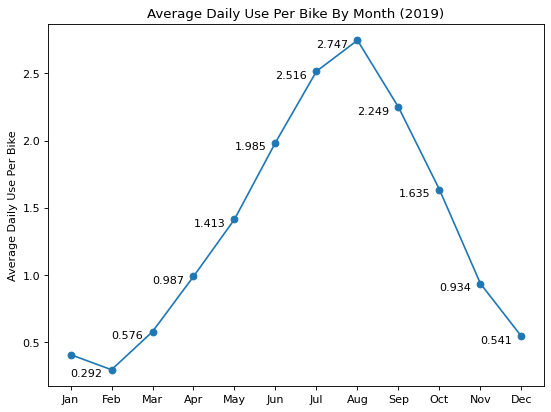

In [32]:
figure(figsize=(8, 6), dpi=80)
plt.plot(list(range(1,13)), avg_daily_use_per_bike_by_month['Average Daily Use Per Bike'], marker='o')
plt.xticks(list(range(1,13)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Average Daily Use Per Bike')
plt.title('Average Daily Use Per Bike By Month (2019)')

for i, v in enumerate(list(avg_daily_use_per_bike_by_month['Average Daily Use Per Bike'])):
    plt.annotate(xy=[i,v-0.05], s=str(v))
plt.show()

## 3.3 Box plot (2019): x=2019, y=trip duration

In [33]:
trip_duration_2019 = data_2019_all_cleaned[['User Type', 'Start Month', 'Trip Duration']]
trip_duration_2019

,User Type,Start Month,Trip Duration
0,Annual Member,1,1547.0
1,Annual Member,1,1112.0
2,Annual Member,1,589.0
3,Annual Member,1,259.0
4,Annual Member,1,281.0
...,...,...,...
2439042,Annual Member,12,523.0
2439043,Annual Member,12,273.0
2439044,Annual Member,12,1055.0
2439045,Annual Member,12,459.0


In [34]:
trip_duration_2019['Trip Duration'].describe()

count    2.439047e+06
mean     1.043352e+03
std      1.853378e+04
min      0.000000e+00
25%      4.250000e+02
50%      6.880000e+02
75%      1.080000e+03
max      1.240378e+07
Name: Trip Duration, dtype: float64

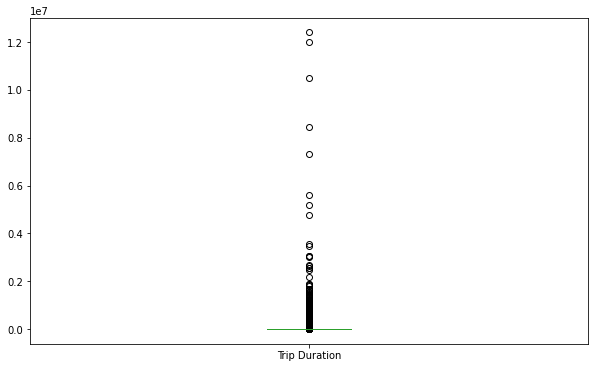

In [35]:
trip_duration_2019['Trip Duration'].plot(kind='box', figsize=(10, 6))

In [36]:
Q1 = trip_duration_2019['Trip Duration'].quantile(0.25)
Q3 = trip_duration_2019['Trip Duration'].quantile(0.75)
IQR = Q3 - Q1

filter_conditions = (trip_duration_2019['Trip Duration'] >= Q1 - 1.5*IQR) & (trip_duration_2019['Trip Duration'] <= Q3 + 1.5*IQR)
trip_duration_2019_outliers_removed = trip_duration_2019.loc[filter_conditions]
trip_duration_2019_outliers_removed

,User Type,Start Month,Trip Duration
0,Annual Member,1,1547.0
1,Annual Member,1,1112.0
2,Annual Member,1,589.0
3,Annual Member,1,259.0
4,Annual Member,1,281.0
...,...,...,...
2439042,Annual Member,12,523.0
2439043,Annual Member,12,273.0
2439044,Annual Member,12,1055.0
2439045,Annual Member,12,459.0


In [37]:
trip_duration_2019_outliers_removed['Trip Duration'].describe()

count    2.345450e+06
mean     7.510240e+02
std      4.292817e+02
min      0.000000e+00
25%      4.150000e+02
50%      6.650000e+02
75%      1.022000e+03
max      2.062000e+03
Name: Trip Duration, dtype: float64

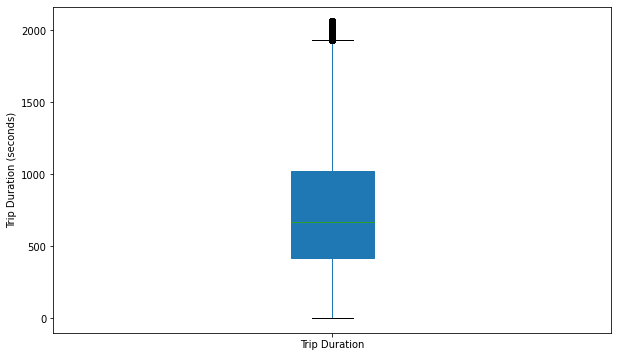

In [38]:
trip_duration_2019_outliers_removed['Trip Duration'].plot(kind='box', figsize=(10, 6), patch_artist=True)
plt.ylabel('Trip Duration (seconds)')
plt.show()

## 3.4 Histograms, 12 subplots (month pattern, 2019): x=trip duration for each month

In [39]:
trip_duration_2019_outliers_removed[['Trip Duration', 'Start Month']].groupby(by=['Start Month']).mean()

,Trip Duration
Start Month,
1,611.665563
2,631.263229
3,634.986304
4,688.222661
5,743.247484
6,809.635926
7,810.647638
8,824.500016
9,757.981615


In [40]:
trip_duration_list = []
for i in range(1, 13):
  temp_list = list(trip_duration_2019_outliers_removed[trip_duration_2019_outliers_removed['Start Month'] == i]['Trip Duration'])
  trip_duration_list.append(temp_list)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


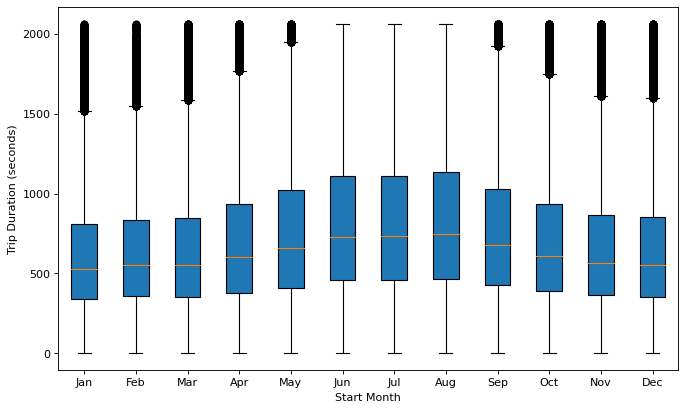

In [41]:
figure(figsize=(10, 6), dpi=80)
plt.boxplot(trip_duration_list, patch_artist=True)
plt.xticks(list(range(1,13)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Start Month')
plt.show()

In [42]:
trip_duration_2019_outliers_removed.head()

,User Type,Start Month,Trip Duration
0,Annual Member,1,1547.0
1,Annual Member,1,1112.0
2,Annual Member,1,589.0
3,Annual Member,1,259.0
4,Annual Member,1,281.0


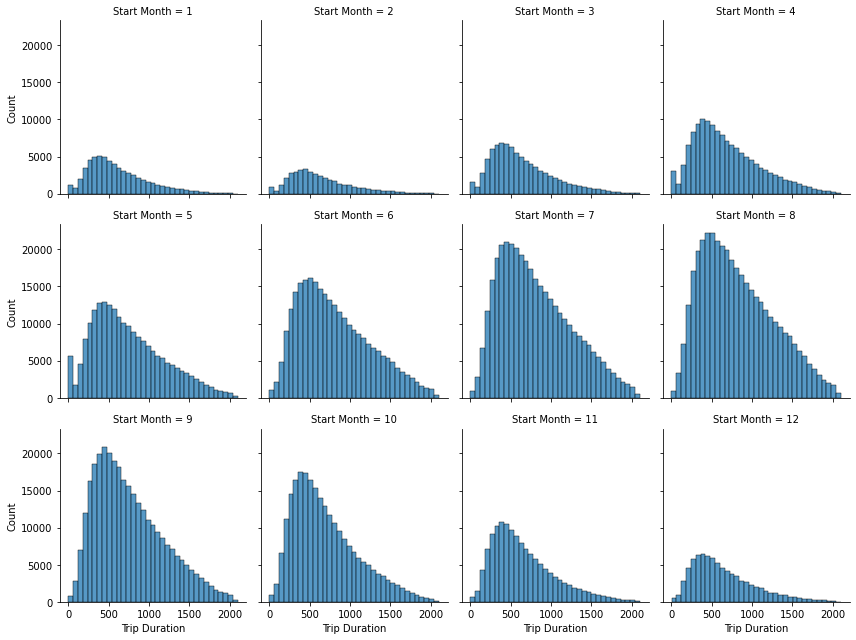

In [43]:
g = sns.FacetGrid(trip_duration_2019_outliers_removed, col='Start Month', col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x='Trip Duration', binwidth=60)

## 3.5 Box plots (week pattern, 2019): x=Mon/Tue/.../Sun, y=number of trips

In [44]:
trip_num_dayofweek = data_2019_all_cleaned[['Trip Id', 'Start Day of Week', 'Start Day of Year', 'User Type']].groupby(by=['Start Day of Year', 'Start Day of Week', 'User Type']).count()
trip_num_dayofweek.rename(columns={'Trip Id': 'Number of Trips'}, inplace=True)
trip_num_dayofweek.reset_index(inplace=True)
print(trip_num_dayofweek.shape)
trip_num_dayofweek.head(15)

(729, 4)


,Start Day of Year,Start Day of Week,User Type,Number of Trips
0,1,1,Annual Member,897
1,1,1,Casual Member,167
2,2,2,Annual Member,2207
3,2,2,Casual Member,83
4,3,3,Annual Member,2228
5,3,3,Casual Member,51
6,4,4,Annual Member,3130
7,4,4,Casual Member,160
8,5,5,Annual Member,1937
9,5,5,Casual Member,223


In [45]:
trip_number_list = []
for i in range(0, 7):
  temp_list = list(trip_num_dayofweek[trip_num_dayofweek['Start Day of Week'] == i]['Number of Trips'])
  trip_number_list.append(temp_list)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


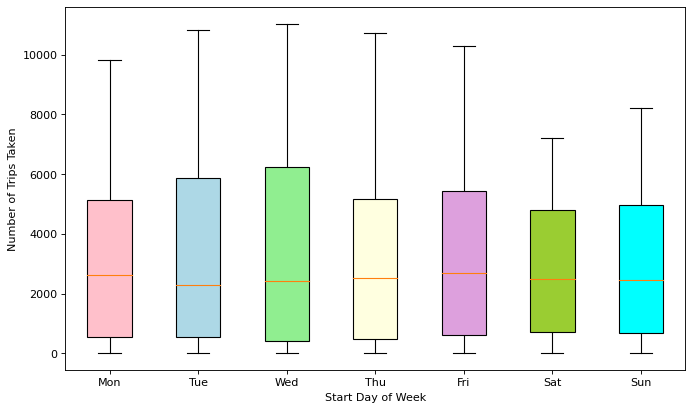

In [46]:
figure(figsize=(10, 6), dpi=80)
bplot = plt.boxplot(trip_number_list, patch_artist=True)
colors = ['pink', 'lightblue', 'lightgreen', 'lightyellow', 'plum', 'yellowgreen', 'aqua']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(list(range(1,8)), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Number of Trips Taken')
plt.xlabel('Start Day of Week')
plt.show()

In [47]:
for i in range(0, 7):
  print('Day of Week Index: {}'.format(i))
  df=trip_num_dayofweek[trip_num_dayofweek['Start Day of Week'] == i]['Number of Trips']
  print(df.describe())

Day of Week Index: 0
count     104.000000
mean     3380.134615
std      3105.593269
min         4.000000
25%       541.000000
50%      2628.500000
75%      5122.750000
max      9812.000000
Name: Number of Trips, dtype: float64
Day of Week Index: 1
count      105.000000
mean      3512.571429
std       3397.936826
min          3.000000
25%        550.000000
50%       2304.000000
75%       5861.000000
max      10811.000000
Name: Number of Trips, dtype: float64
Day of Week Index: 2
count      104.000000
mean      3688.980769
std       3629.338189
min          6.000000
25%        427.250000
50%       2430.500000
75%       6238.000000
max      11029.000000
Name: Number of Trips, dtype: float64
Day of Week Index: 3
count      104.000000
mean      3462.596154
std       3389.510898
min          1.000000
25%        466.750000
50%       2527.500000
75%       5175.000000
max      10732.000000
Name: Number of Trips, dtype: float64
Day of Week Index: 4
count      104.000000
mean      3587.019231
std

## 3.6 Line plots (hour pattern, 2019): x=departure hour, y=number of trips (in this hour on an average weekday/weekend/holiday in 2019), 3 lines -- 1 for weekday (Mon-Fri), 1 for weekend, 1 for holiday

In [48]:
trip_num_hour = data_2019_all_cleaned[['Trip Id', 'Start Day of Week', 'Start Hour', 'Start Week of Year', 'Start Holiday', 'User Type']].groupby(by=['Start Week of Year', 'Start Day of Week', 'Start Hour', 'Start Holiday', 'User Type']).count()
trip_num_hour.rename(columns={'Trip Id': 'Number of Trips'}, inplace=True)
trip_num_hour.reset_index(inplace=True)
print(trip_num_hour.shape)
trip_num_hour

(16126, 6)


,Start Week of Year,Start Day of Week,Start Hour,Start Holiday,User Type,Number of Trips
0,1,0,0,0,Annual Member,5
1,1,0,0,0,Casual Member,1
2,1,0,1,0,Annual Member,5
3,1,0,2,0,Annual Member,8
4,1,0,3,0,Annual Member,1
...,...,...,...,...,...,...
16121,52,6,21,0,Casual Member,2
16122,52,6,22,0,Annual Member,23
16123,52,6,22,0,Casual Member,1
16124,52,6,23,0,Annual Member,9


In [49]:
trip_num_hour_annual = trip_num_hour[trip_num_hour['User Type'] == 'Annual Member']
trip_num_hour_casual = trip_num_hour[trip_num_hour['User Type'] == 'Casual Member']

In [55]:
def filter_weekday_weekend_holidays(df):
  filter_weekday = (df['Start Day of Week'] >= 0) & (df['Start Day of Week']) <= 4 & (df['Start Holiday'] != 1)
  filter_weekend = (df['Start Day of Week'] == 5) | (df['Start Day of Week']) == 6 & (df['Start Holiday'] != 1)
  filter_holidays = (df['Start Holiday'] == 1)

  trip_num_hour_weekday = df.loc[filter_weekday][['Start Hour', 'Number of Trips']]
  trip_num_hour_weekend = df.loc[filter_weekend][['Start Hour', 'Number of Trips']]
  trip_num_hour_holidays = df.loc[filter_holidays][['Start Hour', 'Number of Trips']]

  avg_num_trips_weekday = list(trip_num_hour_weekday.groupby(by='Start Hour').mean().reset_index()['Number of Trips'])
  avg_num_trips_weekend = list(trip_num_hour_weekend.groupby(by='Start Hour').mean().reset_index()['Number of Trips'])
  avg_num_trips_holidays = list(trip_num_hour_holidays.groupby(by='Start Hour').mean().reset_index()['Number of Trips'])

  return [avg_num_trips_weekday, avg_num_trips_weekend, avg_num_trips_holidays]

In [56]:
avg_num_trips_all = filter_weekday_weekend_holidays(trip_num_hour)
avg_num_trips_annual = filter_weekday_weekend_holidays(trip_num_hour_annual)
avg_num_trips_casual = filter_weekday_weekend_holidays(trip_num_hour_casual)

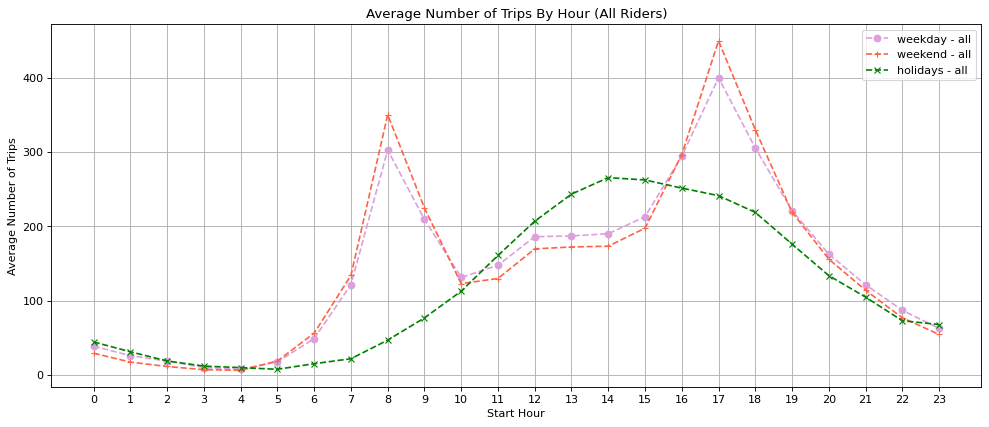

In [57]:
figure(figsize=(15, 6), dpi=80)
plt.plot(list(range(0,24)), avg_num_trips_all[0], linestyle='dashed', marker='o', label='weekday - all', color='plum')
plt.plot(list(range(0,24)), avg_num_trips_all[1], linestyle='dashed', marker='+', label='weekend - all', color='tomato')
plt.plot(list(range(0,24)), avg_num_trips_all[2], linestyle='dashed', marker='x', label='holidays - all', color='green')

plt.xticks(list(range(0,24)), list(range(0,24)))
plt.xlabel('Start Hour')
plt.ylabel('Average Number of Trips')
plt.title('Average Number of Trips By Hour (All Riders)')
plt.legend()
plt.grid()
plt.show()

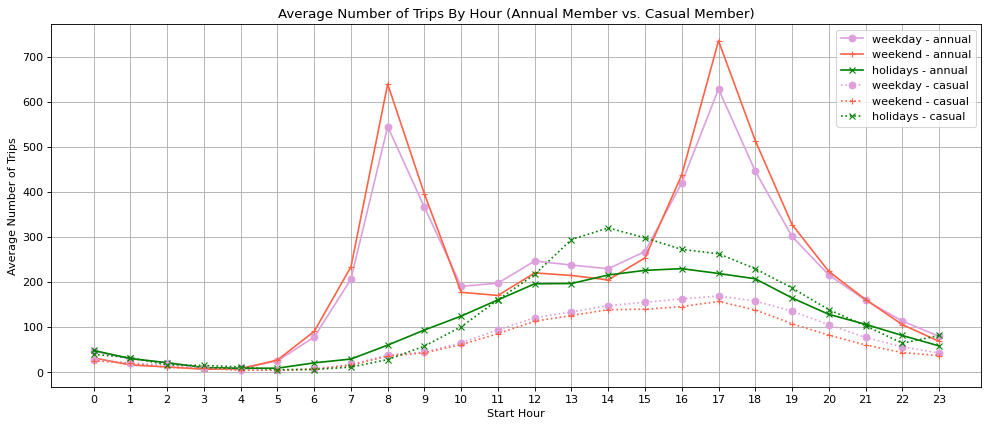

In [58]:
figure(figsize=(15, 6), dpi=80)

plt.plot(list(range(0,24)), avg_num_trips_annual[0], linestyle='solid', marker='o', label='weekday - annual', color='plum')
plt.plot(list(range(0,24)), avg_num_trips_annual[1], linestyle='solid', marker='+', label='weekend - annual', color='tomato')
plt.plot(list(range(0,24)), avg_num_trips_annual[2], linestyle='solid', marker='x', label='holidays - annual', color='green')

plt.plot(list(range(0,24)), avg_num_trips_casual[0], linestyle='dotted', marker='o', label='weekday - casual', color='plum')
plt.plot(list(range(0,24)), avg_num_trips_casual[1], linestyle='dotted', marker='+', label='weekend - casual', color='tomato')
plt.plot(list(range(0,24)), avg_num_trips_casual[2], linestyle='dotted', marker='x', label='holidays - casual', color='green')

plt.xticks(list(range(0,24)), list(range(0,24)))
plt.xlabel('Start Hour')
plt.ylabel('Average Number of Trips')
plt.title('Average Number of Trips By Hour (Annual Member vs. Casual Member)')
plt.legend()
plt.grid()
plt.show()